In [1]:
from keras.layers import Lambda, Input, Dense, Reshape, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

from keras.metrics import categorical_crossentropy

import tensorflow as tf
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, mean_squared_error

import pandas as pd
import numpy as np
import xarray as xr

from scipy import stats
import xesmf as xe
from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

import clustering_functions as cf
import skill_functions as sf
import preprocessing_functions as pf

2024-11-07 16:06:50.020409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]

#### Parameters

In [3]:
import yaml
from yaml import CLoader as Loader

# CHANGE
cluster_number = 7
reconstruction_loss_factor = 0.5
filepath = "results/cmmvae/"

pr_cluster_number = 5

original_dim = 825
inputdim1 = 25
inputdim2 = 33

latent_dim = 15

activation_function = 'relu'

dim_layer1 = 256
dim_layer2 = 128
dim_layer3 = 64

cat_dim = 1

batch_size = 128
epochs = 150

input_shape = (original_dim, )
input_shape_r = (pr_cluster_number, )

In [4]:
# sampling function

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

### Data pre-processing

In [6]:
z500 = pf.preprocess_dataset(filename = '../data.nosync/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

In [7]:
# CHIRPS

pr_labels = pd.read_csv('../data.nosync/CHIRPS_pr_cluster_labels_5.csv')
pr_labels.columns = ['index', 'labels']
pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

threshold_qn95 = xr.open_dataset('../data.nosync/CHIRPS_pr_95pc_EW.nc')
threshold_qn95 = threshold_qn95.where(threshold_qn95['time.year'] < 2023, drop=True)['precipitation_amount']

pr_spatial = xr.open_dataset('../data.nosync/CHIRPS_pr_total_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

## Define model

**Encoder**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 encoder_intermediate (Dens  (None, 256)                  211456    ['encoder_input[0][0]']       
 e)                                                                                               
                                                                                                  
 encoder_intermediate_2 (De  (None, 128)                  32896     ['encoder_intermediate[0][0]']
 nse)                                                                                             
                                                                                            

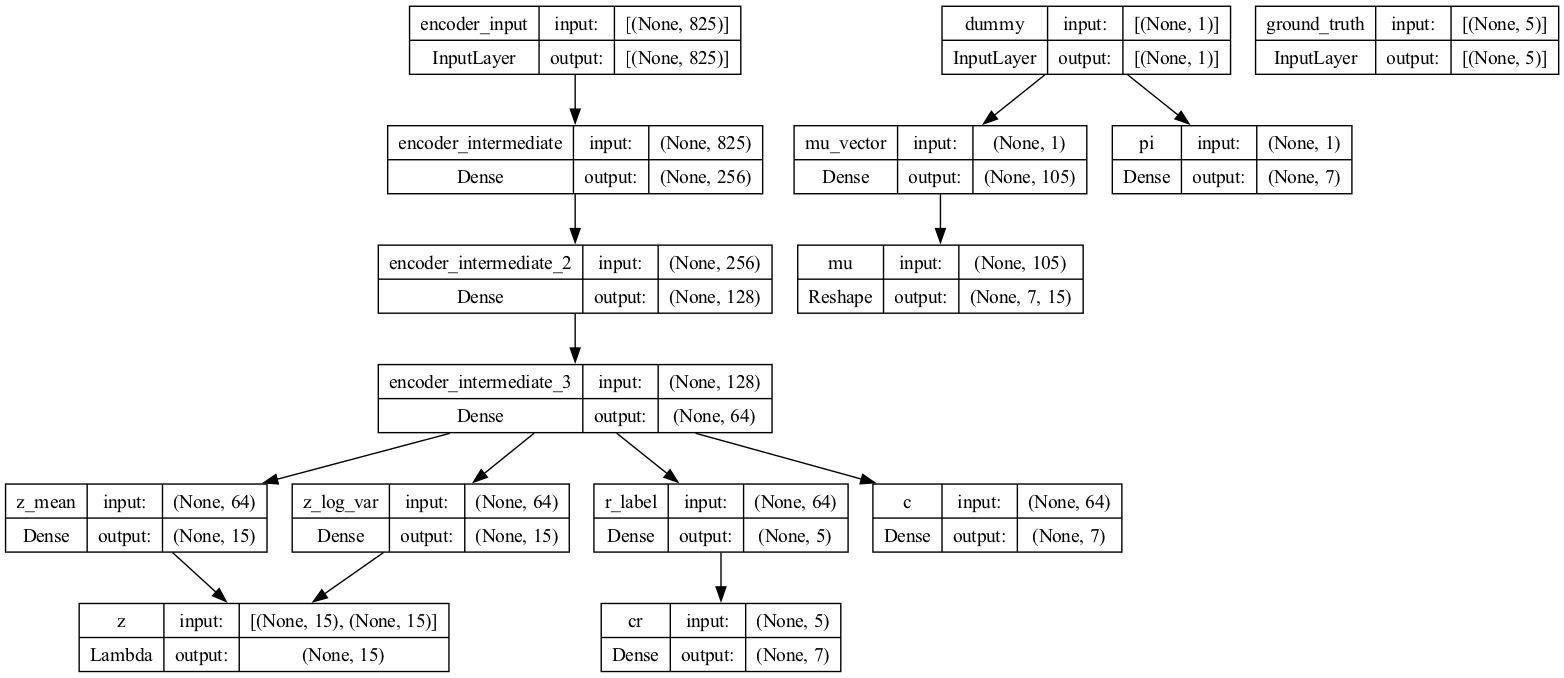

In [8]:
inputs_x = Input(shape=input_shape, name='encoder_input')
inputs_r = Input(shape=input_shape_r, name='ground_truth')

inter_x1 = Dense(dim_layer1, activation=activation_function, name='encoder_intermediate')(inputs_x)
inter_x2 = Dense(dim_layer2, activation=activation_function, name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(dim_layer3, activation=activation_function, name='encoder_intermediate_3')(inter_x2)

dummy = Input(shape=(1,), name='dummy')
mu_vector = Dense(cluster_number*latent_dim, name='mu_vector',use_bias=False)(dummy)
mu = Reshape((cluster_number,latent_dim), name='mu')(mu_vector)

pi = Dense(cluster_number, activation='softmax', name='pi')(dummy)
c = Dense(cluster_number, activation='softmax', name='c')(inter_x3)

z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

r = Dense(pr_cluster_number, name='r_label', activation='softmax')(inter_x3)

cr = Dense(cluster_number, activation='softmax', name='cr')(r)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,dummy, inputs_r], [z_mean, z_log_var, z, mu, c, pi, r, cr], name='encoder')

encoder.summary()
plot_model(encoder, show_shapes=True, dpi=100)
plot_model(encoder, to_file=filepath+'encoder_graph.png', show_shapes=True, dpi=100)

**Decoder**

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 15)]              0         
                                                                 
 dense (Dense)               (None, 64)                1024      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 825)               212025    
                                                                 
Total params: 254393 (993.72 KB)
Trainable params: 254393 (993.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


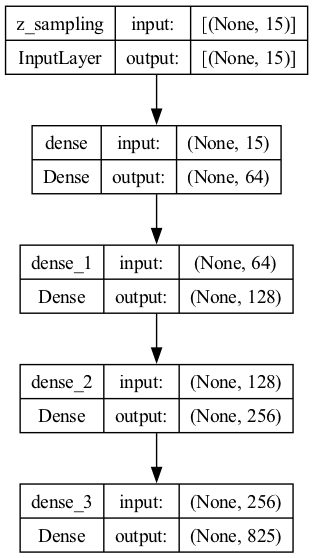

In [9]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

inter_y1 = Dense(dim_layer3, activation=activation_function)(latent_inputs)
inter_y2 = Dense(dim_layer2, activation=activation_function)(inter_y1)
inter_y3 = Dense(dim_layer1, activation=activation_function)(inter_y2)

outputs = Dense(original_dim)(inter_y3)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, dpi=100)
plot_model(decoder, to_file=filepath+'decoder_graph.png', show_shapes=True, dpi=100)

**combine encoder and decoder to VAE model and print summary**

In [10]:
outputs = decoder(encoder([inputs_x, dummy, inputs_r])[2])

vae = Model([inputs_x,dummy, inputs_r], outputs, name='vae_classification')

vae.summary()

Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255499    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0]

### Loss function

In [11]:
reconstruction_loss = mse(inputs_x, outputs)*original_dim*reconstruction_loss_factor

prediction_loss = categorical_crossentropy(c, cr)

target_loss = (categorical_crossentropy(inputs_r, r) + categorical_crossentropy(r, r))*pr_cluster_number

kl_loss_all = tf.compat.v1.get_variable("kl_loss_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)

kl_cat_all = tf.compat.v1.get_variable("kl_cat_all", [batch_size,1], 
                                dtype=tf.float32,initializer=tf.zeros_initializer)
dir_prior_all = tf.compat.v1.get_variable("dir_prior_all", [batch_size,1], 
                                  dtype=tf.float32,initializer=tf.zeros_initializer)

for i in range(0,cluster_number):
    
    kl_loss = 1 + z_log_var - tf.math.square(z_mean-mu[:,i,:]) - tf.math.exp(z_log_var)
    kl_loss = tf.multiply(tf.reduce_sum(kl_loss, axis=-1), c[:,i])
    kl_loss = -0.5*(kl_loss)
    kl_loss_all = kl_loss_all + kl_loss
    
    mc = tf.reduce_mean(c[:,i])
    mpi = tf.reduce_mean(pi[:,i])
    kl_cat = mc * tf.math.log(mc)- mc * tf.math.log(mpi)
    kl_cat_all = kl_cat_all+kl_cat
    
    dir_prior = -tf.math.log(pi[:,i])*0.5
    dir_prior_all = dir_prior_all + dir_prior

**Set loss function for model**

In [12]:
vae_loss = K.mean(reconstruction_loss+prediction_loss+target_loss+kl_loss_all+kl_cat_all+dir_prior_all)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.save_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')

Model: "vae_classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 825)]                0         []                            
                                                                                                  
 dummy (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 5)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 15),                 255499    ['encoder_input[0][0]',       
                              (None, 15),                            'dummy[0][0]

                                                                                                  
 pi (Dense)                  (None, 7)                    14        ['dummy[0][0]']               
                                                                                                  
 tf.math.subtract_2 (TFOpLa  (None, 15)                   0         ['tf.math.subtract_1[0][0]',  
 mbda)                                                               'tf.math.exp[0][0]']         
                                                                                                  
 tf.math.subtract_5 (TFOpLa  (None, 15)                   0         ['tf.__operators__.add_5[0][0]
 mbda)                                                              ',                            
                                                                     'tf.math.square_1[0][0]']    
                                                                                                  
 tf.math.e

                                                                                                  
 tf.math.subtract_13 (TFOpL  (None, 15)                   0         ['tf.__operators__.add_13[0][0
 ambda)                                                             ]',                           
                                                                     'tf.math.square_3[0][0]']    
                                                                                                  
 tf.math.exp_3 (TFOpLambda)  (None, 15)                   0         ['z_log_var[0][0]']           
                                                                                                  
 tf.__operators__.add_17 (T  (None, 15)                   0         ['z_log_var[0][0]']           
 FOpLambda)                                                                                       
                                                                                                  
 tf.math.s

                                                                    ]                             
                                                                                                  
 tf.math.reduce_mean_5 (TFO  ()                           0         ['tf.__operators__.getitem_12[
 pLambda)                                                           0][0]']                       
                                                                                                  
 tf.math.reduce_mean_6 (TFO  ()                           0         ['tf.__operators__.getitem_13[
 pLambda)                                                           0][0]']                       
                                                                                                  
 tf.__operators__.getitem_1  (None,)                      0         ['c[0][0]']                   
 7 (SlicingOpLambda)                                                                              
          

 tf.math.negative (TFOpLamb  (None,)                      0         ['tf.math.log_2[0][0]']       
 da)                                                                                              
                                                                                                  
 tf.math.log_5 (TFOpLambda)  (None,)                      0         ['tf.__operators__.getitem_9[0
                                                                    ][0]']                        
                                                                                                  
 tf.__operators__.getitem_1  (None,)                      0         ['pi[0][0]']                  
 4 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.math.squared_difference  (None, 825)                  0         ['tf.convert_to_tensor[0][0]',
  (TFOpLam

 tf.math.reduce_mean (TFOpL  (None,)                      0         ['tf.math.squared_difference[0
 ambda)                                                             ][0]']                        
                                                                                                  
 cr (Dense)                  (None, 7)                    42        ['r_label[0][0]']             
                                                                                                  
 tf.cast_2 (TFOpLambda)      (None, 5)                    0         ['ground_truth[0][0]']        
                                                                                                  
 tf.convert_to_tensor_4 (TF  (None, 5)                    0         ['r_label[0][0]']             
 OpLambda)                                                                                        
                                                                                                  
 tf.cast_3

                                                                                                  
 tf.cast_1 (TFOpLambda)      (None, 7)                    0         ['c[0][0]']                   
                                                                                                  
 tf.convert_to_tensor_1 (TF  (None, 7)                    0         ['cr[0][0]']                  
 OpLambda)                                                                                        
                                                                                                  
 tf.keras.backend.categoric  (None,)                      0         ['tf.cast_2[0][0]',           
 al_crossentropy_1 (TFOpLam                                          'tf.convert_to_tensor_4[0][0]
 bda)                                                               ']                            
                                                                                                  
 tf.keras.

                                                                                                  
 tf.__operators__.add_18 (T  (128, None)                  0         ['tf.__operators__.add_14[0][0
 FOpLambda)                                                         ]',                           
                                                                     'tf.math.multiply_24[0][0]'] 
                                                                                                  
 tf.math.multiply_29 (TFOpL  (None,)                      0         ['tf.math.multiply_28[0][0]'] 
 ambda)                                                                                           
                                                                                                  
 tf.math.multiply_33 (TFOpL  (None,)                      0         ['tf.math.reduce_sum_6[0][0]',
 ambda)                                                              'tf.__operators__.getitem_31[
          

 ambda)                                                                                           
                                                                                                  
 tf.math.negative_5 (TFOpLa  (None,)                      0         ['tf.math.log_17[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.math.log_20 (TFOpLambda  (None,)                      0         ['tf.__operators__.getitem_34[
 )                                                                  0][0]']                       
                                                                                                  
 tf.__operators__.add_30 (T  (None,)                      0         ['tf.__operators__.add_29[0][0
 FOpLambda)                                                         ]',                           
          

## Train model 

In [13]:
X = cf.reshape_data_for_clustering(z500)
y = label_indices
dummy_full = np.ones((X.shape[0],1))

**Test convergence of loss function**

Epoch 1/150
35/35 [==============================] - 7s 48ms/step - loss: 372.9269 - val_loss: 257.6517
Epoch 2/150
35/35 [==============================] - 0s 14ms/step - loss: 187.7732 - val_loss: 152.7891
Epoch 3/150
35/35 [==============================] - 0s 13ms/step - loss: 141.1908 - val_loss: 133.1352
Epoch 4/150
35/35 [==============================] - 0s 13ms/step - loss: 128.1416 - val_loss: 121.2143
Epoch 5/150
35/35 [==============================] - 0s 14ms/step - loss: 112.9063 - val_loss: 105.0843
Epoch 6/150
35/35 [==============================] - 0s 14ms/step - loss: 99.1084 - val_loss: 96.2741
Epoch 7/150
35/35 [==============================] - 0s 14ms/step - loss: 93.8802 - val_loss: 92.2131
Epoch 8/150
35/35 [==============================] - 0s 14ms/step - loss: 88.9144 - val_loss: 88.3471
Epoch 9/150
35/35 [==============================] - 1s 15ms/step - loss: 85.5962 - val_loss: 85.5672
Epoch 10/150
35/35 [==============================] - 0s 14ms/step - los

35/35 [==============================] - 0s 13ms/step - loss: 54.1172 - val_loss: 59.5548
Epoch 81/150
35/35 [==============================] - 0s 14ms/step - loss: 54.5420 - val_loss: 59.2578
Epoch 82/150
35/35 [==============================] - 0s 14ms/step - loss: 53.9052 - val_loss: 58.4382
Epoch 83/150
35/35 [==============================] - 0s 14ms/step - loss: 53.7539 - val_loss: 58.6748
Epoch 84/150
35/35 [==============================] - 0s 13ms/step - loss: 53.7528 - val_loss: 58.7195
Epoch 85/150
35/35 [==============================] - 0s 14ms/step - loss: 53.6841 - val_loss: 58.1216
Epoch 86/150
35/35 [==============================] - 0s 14ms/step - loss: 53.5687 - val_loss: 58.8369
Epoch 87/150
35/35 [==============================] - 0s 13ms/step - loss: 53.7685 - val_loss: 58.4573
Epoch 88/150
35/35 [==============================] - 0s 13ms/step - loss: 53.4820 - val_loss: 59.0473
Epoch 89/150
35/35 [==============================] - 0s 13ms/step - loss: 53.7173 - v

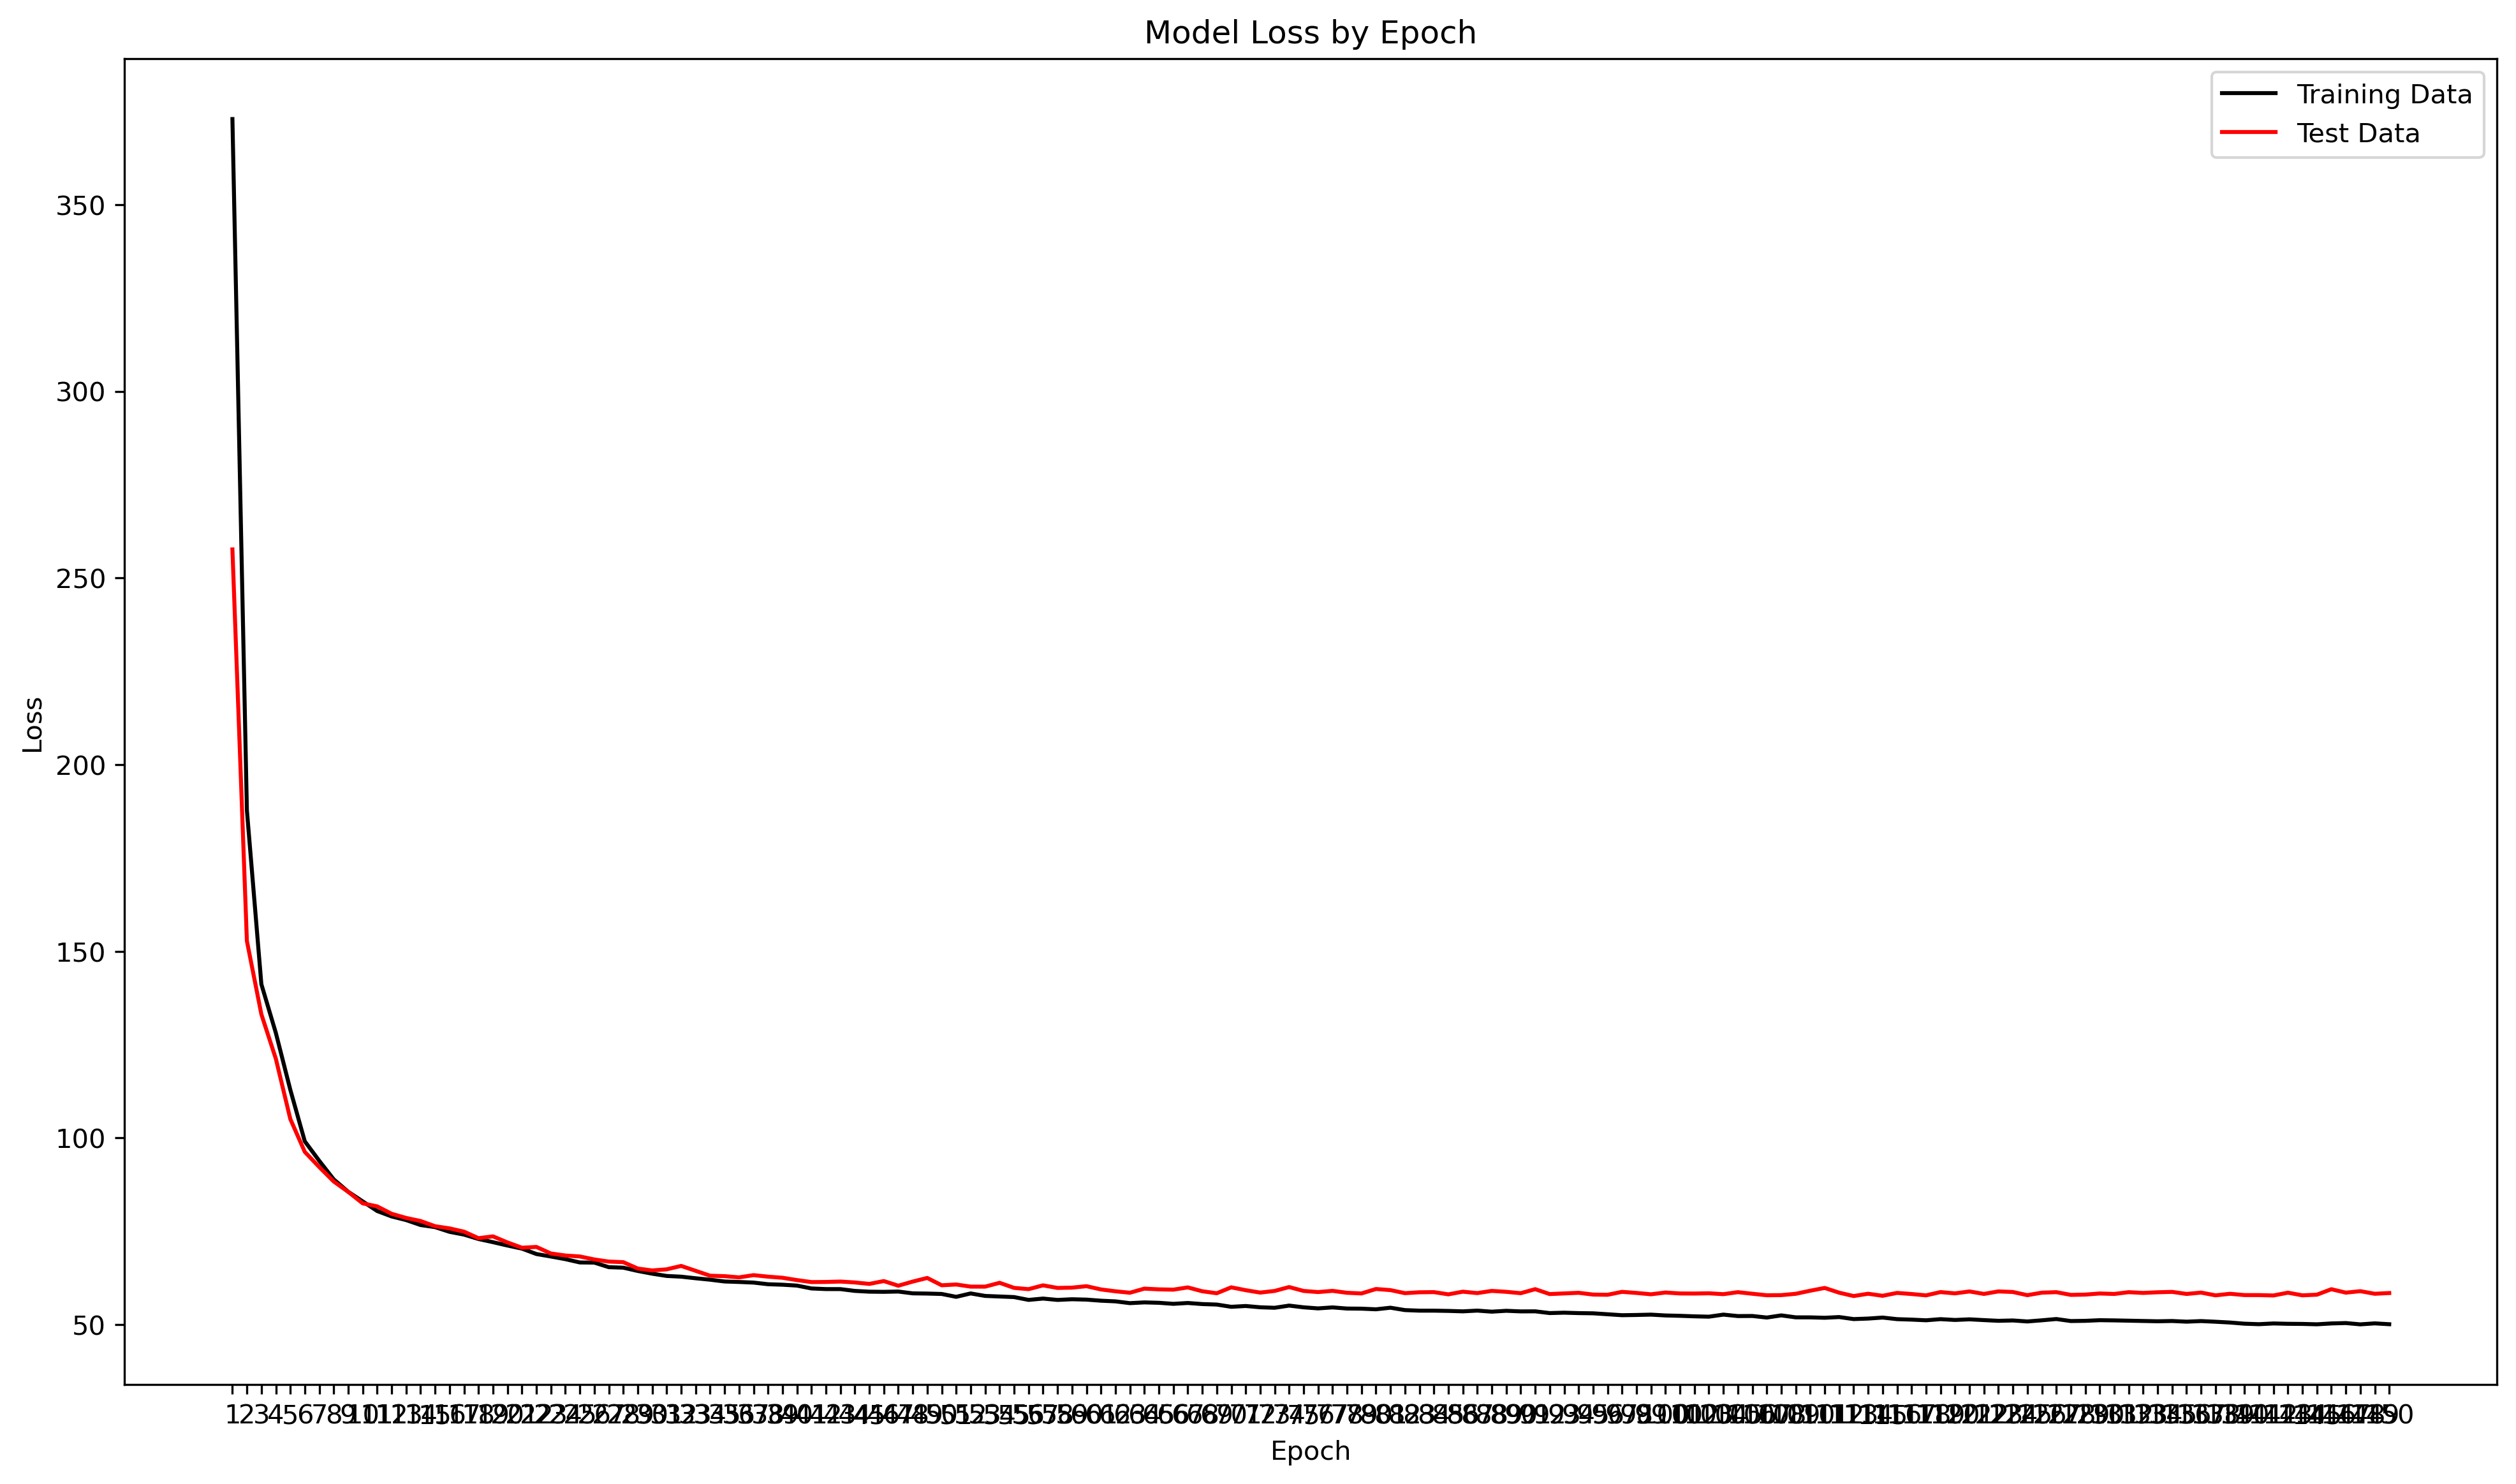

In [14]:
X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.3)

nt,ny,nx = X_train_1.shape
X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

nt,ny,nx = X_test_1.shape
X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

dummy_train = np.ones((X_train.shape[0],1))
dummy_test = np.ones((X_test.shape[0],1))

vae.load_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')

history = vae.fit([X_train, dummy_train, y_train], [X_train, dummy_train, y_train], epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=([X_test,dummy_test,y_test], [X_test,dummy_test,y_test]))
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

#### Cross-validation of model

In [15]:
for count in range(20):
    
    X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.3)

    nt,ny,nx = X_train_1.shape
    X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

    nt,ny,nx = X_test_1.shape
    X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

    dummy_train = np.ones((X_train.shape[0],1))
    dummy_test = np.ones((X_test.shape[0],1))

    vae.load_weights(filepath+'random_weights_'+str(cluster_number)+'.h5')

    history = vae.fit([X_train, dummy_train, y_train], [X_train, dummy_train, y_train], epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=([X_test,dummy_test,y_test], [X_test,dummy_test,y_test]))
    
    vae.save_weights(filepath+'final_weights_'+str(cluster_number)+'_'+str(count)+'.h5')

Epoch 1/150
35/35 [==============================] - 1s 15ms/step - loss: 373.5952 - val_loss: 245.2266
Epoch 2/150
35/35 [==============================] - 0s 14ms/step - loss: 180.1239 - val_loss: 148.2878
Epoch 3/150
35/35 [==============================] - 0s 13ms/step - loss: 137.3002 - val_loss: 135.2493
Epoch 4/150
35/35 [==============================] - 0s 13ms/step - loss: 128.5358 - val_loss: 126.3103
Epoch 5/150
35/35 [==============================] - 0s 13ms/step - loss: 117.6016 - val_loss: 116.8414
Epoch 6/150
35/35 [==============================] - 0s 13ms/step - loss: 110.5387 - val_loss: 109.5993
Epoch 7/150
35/35 [==============================] - 1s 16ms/step - loss: 103.3030 - val_loss: 102.9515
Epoch 8/150
35/35 [==============================] - 1s 14ms/step - loss: 97.4800 - val_loss: 96.3441
Epoch 9/150
35/35 [==============================] - 1s 15ms/step - loss: 92.0310 - val_loss: 92.8837
Epoch 10/150
35/35 [==============================] - 1s 15ms/step -

35/35 [==============================] - 0s 13ms/step - loss: 54.5198 - val_loss: 58.5392
Epoch 81/150
35/35 [==============================] - 0s 12ms/step - loss: 54.6035 - val_loss: 58.4109
Epoch 82/150
35/35 [==============================] - 0s 13ms/step - loss: 54.2142 - val_loss: 58.3677
Epoch 83/150
35/35 [==============================] - 0s 14ms/step - loss: 53.7929 - val_loss: 57.9214
Epoch 84/150
35/35 [==============================] - 1s 16ms/step - loss: 53.5442 - val_loss: 58.2654
Epoch 85/150
35/35 [==============================] - 0s 14ms/step - loss: 53.5188 - val_loss: 58.1918
Epoch 86/150
35/35 [==============================] - 1s 16ms/step - loss: 53.8301 - val_loss: 58.4622
Epoch 87/150
35/35 [==============================] - 1s 15ms/step - loss: 53.5903 - val_loss: 58.2444
Epoch 88/150
35/35 [==============================] - 1s 19ms/step - loss: 53.5604 - val_loss: 58.7916
Epoch 89/150
35/35 [==============================] - 1s 15ms/step - loss: 53.5744 - v

35/35 [==============================] - 0s 12ms/step - loss: 89.7421 - val_loss: 88.3501
Epoch 10/150
35/35 [==============================] - 0s 12ms/step - loss: 86.1111 - val_loss: 84.8879
Epoch 11/150
35/35 [==============================] - 0s 13ms/step - loss: 83.3049 - val_loss: 83.1627
Epoch 12/150
35/35 [==============================] - 1s 15ms/step - loss: 80.9947 - val_loss: 80.6577
Epoch 13/150
35/35 [==============================] - 0s 14ms/step - loss: 79.5488 - val_loss: 78.7026
Epoch 14/150
35/35 [==============================] - 0s 14ms/step - loss: 77.1987 - val_loss: 76.5967
Epoch 15/150
35/35 [==============================] - 0s 13ms/step - loss: 75.8326 - val_loss: 75.6371
Epoch 16/150
35/35 [==============================] - 0s 14ms/step - loss: 74.1680 - val_loss: 73.7834
Epoch 17/150
35/35 [==============================] - 0s 14ms/step - loss: 72.7466 - val_loss: 73.0488
Epoch 18/150
35/35 [==============================] - 0s 13ms/step - loss: 71.8962 - v

35/35 [==============================] - 0s 13ms/step - loss: 53.4765 - val_loss: 57.0808
Epoch 89/150
35/35 [==============================] - 0s 13ms/step - loss: 52.9881 - val_loss: 57.6046
Epoch 90/150
35/35 [==============================] - 0s 12ms/step - loss: 52.9207 - val_loss: 56.8446
Epoch 91/150
35/35 [==============================] - 0s 12ms/step - loss: 52.8605 - val_loss: 57.2115
Epoch 92/150
35/35 [==============================] - 0s 12ms/step - loss: 52.7365 - val_loss: 57.0990
Epoch 93/150
35/35 [==============================] - 0s 13ms/step - loss: 52.9075 - val_loss: 57.5884
Epoch 94/150
35/35 [==============================] - 0s 12ms/step - loss: 52.8739 - val_loss: 57.6524
Epoch 95/150
35/35 [==============================] - 0s 13ms/step - loss: 52.5045 - val_loss: 57.8696
Epoch 96/150
35/35 [==============================] - 1s 15ms/step - loss: 52.6509 - val_loss: 56.6660
Epoch 97/150
35/35 [==============================] - 1s 15ms/step - loss: 52.3143 - v

35/35 [==============================] - 0s 13ms/step - loss: 74.3064 - val_loss: 75.8861
Epoch 18/150
35/35 [==============================] - 1s 23ms/step - loss: 73.1798 - val_loss: 74.7381
Epoch 19/150
35/35 [==============================] - 1s 17ms/step - loss: 72.0424 - val_loss: 74.1398
Epoch 20/150
35/35 [==============================] - 0s 12ms/step - loss: 71.5005 - val_loss: 72.8729
Epoch 21/150
35/35 [==============================] - 0s 12ms/step - loss: 70.5874 - val_loss: 71.8130
Epoch 22/150
35/35 [==============================] - 0s 13ms/step - loss: 70.0655 - val_loss: 71.4717
Epoch 23/150
35/35 [==============================] - 1s 15ms/step - loss: 69.5697 - val_loss: 71.2049
Epoch 24/150
35/35 [==============================] - 0s 14ms/step - loss: 68.7536 - val_loss: 70.8780
Epoch 25/150
35/35 [==============================] - 1s 15ms/step - loss: 68.0577 - val_loss: 69.4139
Epoch 26/150
35/35 [==============================] - 1s 15ms/step - loss: 67.3455 - v

35/35 [==============================] - 0s 13ms/step - loss: 52.2488 - val_loss: 58.4768
Epoch 97/150
35/35 [==============================] - 0s 13ms/step - loss: 51.9845 - val_loss: 57.7183
Epoch 98/150
35/35 [==============================] - 0s 12ms/step - loss: 52.2184 - val_loss: 58.2473
Epoch 99/150
35/35 [==============================] - 0s 12ms/step - loss: 52.2448 - val_loss: 57.5674
Epoch 100/150
35/35 [==============================] - 0s 13ms/step - loss: 52.1548 - val_loss: 58.8484
Epoch 101/150
35/35 [==============================] - 0s 13ms/step - loss: 51.9521 - val_loss: 57.2545
Epoch 102/150
35/35 [==============================] - 0s 13ms/step - loss: 51.9973 - val_loss: 58.0473
Epoch 103/150
35/35 [==============================] - 0s 12ms/step - loss: 51.6501 - val_loss: 57.6792
Epoch 104/150
35/35 [==============================] - 0s 12ms/step - loss: 51.8387 - val_loss: 57.6101
Epoch 105/150
35/35 [==============================] - 0s 12ms/step - loss: 51.58

35/35 [==============================] - 0s 12ms/step - loss: 66.6735 - val_loss: 67.9563
Epoch 26/150
35/35 [==============================] - 0s 12ms/step - loss: 65.9834 - val_loss: 67.7832
Epoch 27/150
35/35 [==============================] - 0s 12ms/step - loss: 65.7851 - val_loss: 67.1669
Epoch 28/150
35/35 [==============================] - 0s 13ms/step - loss: 65.6000 - val_loss: 66.5901
Epoch 29/150
35/35 [==============================] - 0s 14ms/step - loss: 64.8857 - val_loss: 66.3574
Epoch 30/150
35/35 [==============================] - 0s 14ms/step - loss: 64.4130 - val_loss: 66.4011
Epoch 31/150
35/35 [==============================] - 0s 14ms/step - loss: 64.2318 - val_loss: 65.3822
Epoch 32/150
35/35 [==============================] - 0s 13ms/step - loss: 63.7531 - val_loss: 64.8767
Epoch 33/150
35/35 [==============================] - 0s 14ms/step - loss: 63.2038 - val_loss: 64.5308
Epoch 34/150
35/35 [==============================] - 0s 14ms/step - loss: 62.5568 - v

35/35 [==============================] - 0s 13ms/step - loss: 52.4558 - val_loss: 57.2933
Epoch 105/150
35/35 [==============================] - 0s 14ms/step - loss: 52.2492 - val_loss: 57.0830
Epoch 106/150
35/35 [==============================] - 1s 15ms/step - loss: 51.9815 - val_loss: 57.5936
Epoch 107/150
35/35 [==============================] - 1s 16ms/step - loss: 51.9435 - val_loss: 56.8488
Epoch 108/150
35/35 [==============================] - 1s 17ms/step - loss: 51.9546 - val_loss: 57.1639
Epoch 109/150
35/35 [==============================] - 1s 15ms/step - loss: 51.9502 - val_loss: 57.3255
Epoch 110/150
35/35 [==============================] - 1s 16ms/step - loss: 52.4739 - val_loss: 56.7925
Epoch 111/150
35/35 [==============================] - 1s 18ms/step - loss: 51.8520 - val_loss: 57.0280
Epoch 112/150
35/35 [==============================] - 1s 19ms/step - loss: 52.0032 - val_loss: 57.5567
Epoch 113/150
35/35 [==============================] - 1s 18ms/step - loss: 51

35/35 [==============================] - 0s 14ms/step - loss: 62.9959 - val_loss: 64.6112
Epoch 34/150
35/35 [==============================] - 0s 14ms/step - loss: 62.4116 - val_loss: 64.4424
Epoch 35/150
35/35 [==============================] - 0s 14ms/step - loss: 62.8965 - val_loss: 64.0741
Epoch 36/150
35/35 [==============================] - 1s 17ms/step - loss: 62.2178 - val_loss: 64.0351
Epoch 37/150
35/35 [==============================] - 0s 13ms/step - loss: 61.8221 - val_loss: 64.0822
Epoch 38/150
35/35 [==============================] - 0s 13ms/step - loss: 61.8896 - val_loss: 63.7041
Epoch 39/150
35/35 [==============================] - 0s 13ms/step - loss: 61.6386 - val_loss: 63.4389
Epoch 40/150
35/35 [==============================] - 0s 13ms/step - loss: 61.0951 - val_loss: 63.7646
Epoch 41/150
35/35 [==============================] - 0s 13ms/step - loss: 60.9326 - val_loss: 63.2805
Epoch 42/150
35/35 [==============================] - 0s 13ms/step - loss: 60.7903 - v

35/35 [==============================] - 0s 12ms/step - loss: 52.0340 - val_loss: 57.0159
Epoch 113/150
35/35 [==============================] - 0s 12ms/step - loss: 51.9478 - val_loss: 57.6273
Epoch 114/150
35/35 [==============================] - 0s 12ms/step - loss: 51.8791 - val_loss: 57.7187
Epoch 115/150
35/35 [==============================] - 0s 14ms/step - loss: 51.7054 - val_loss: 56.8630
Epoch 116/150
35/35 [==============================] - 0s 12ms/step - loss: 51.6128 - val_loss: 56.7405
Epoch 117/150
35/35 [==============================] - 1s 19ms/step - loss: 51.5783 - val_loss: 57.4672
Epoch 118/150
35/35 [==============================] - 1s 14ms/step - loss: 51.7710 - val_loss: 57.4614
Epoch 119/150
35/35 [==============================] - 1s 18ms/step - loss: 51.8061 - val_loss: 57.4988
Epoch 120/150
35/35 [==============================] - 1s 16ms/step - loss: 51.4023 - val_loss: 56.7978
Epoch 121/150
35/35 [==============================] - 1s 15ms/step - loss: 51

35/35 [==============================] - 0s 13ms/step - loss: 60.8550 - val_loss: 63.9231
Epoch 42/150
35/35 [==============================] - 0s 13ms/step - loss: 60.1947 - val_loss: 63.8364
Epoch 43/150
35/35 [==============================] - 0s 13ms/step - loss: 59.9621 - val_loss: 62.9967
Epoch 44/150
35/35 [==============================] - 0s 13ms/step - loss: 59.4422 - val_loss: 63.0360
Epoch 45/150
35/35 [==============================] - 0s 13ms/step - loss: 59.6803 - val_loss: 62.2955
Epoch 46/150
35/35 [==============================] - 0s 13ms/step - loss: 59.4081 - val_loss: 62.9186
Epoch 47/150
35/35 [==============================] - 0s 13ms/step - loss: 59.1680 - val_loss: 62.9763
Epoch 48/150
35/35 [==============================] - 0s 13ms/step - loss: 58.9147 - val_loss: 62.3651
Epoch 49/150
35/35 [==============================] - 0s 13ms/step - loss: 58.6360 - val_loss: 61.6350
Epoch 50/150
35/35 [==============================] - 0s 13ms/step - loss: 58.2886 - v

35/35 [==============================] - 0s 11ms/step - loss: 50.6929 - val_loss: 57.8887
Epoch 121/150
35/35 [==============================] - 0s 12ms/step - loss: 50.7763 - val_loss: 58.8878
Epoch 122/150
35/35 [==============================] - 0s 12ms/step - loss: 50.9210 - val_loss: 58.6158
Epoch 123/150
35/35 [==============================] - 0s 14ms/step - loss: 51.0479 - val_loss: 58.4151
Epoch 124/150
35/35 [==============================] - 0s 12ms/step - loss: 50.5997 - val_loss: 58.5547
Epoch 125/150
35/35 [==============================] - 0s 12ms/step - loss: 50.2958 - val_loss: 58.0993
Epoch 126/150
35/35 [==============================] - 0s 12ms/step - loss: 50.7497 - val_loss: 58.4821
Epoch 127/150
35/35 [==============================] - 0s 12ms/step - loss: 50.3631 - val_loss: 58.5040
Epoch 128/150
35/35 [==============================] - 0s 12ms/step - loss: 50.5420 - val_loss: 58.2691
Epoch 129/150
35/35 [==============================] - 0s 12ms/step - loss: 49

35/35 [==============================] - 0s 13ms/step - loss: 58.1072 - val_loss: 59.9231
Epoch 50/150
35/35 [==============================] - 0s 14ms/step - loss: 57.6525 - val_loss: 59.5032
Epoch 51/150
35/35 [==============================] - 0s 13ms/step - loss: 57.5075 - val_loss: 59.3181
Epoch 52/150
35/35 [==============================] - 0s 12ms/step - loss: 57.4145 - val_loss: 58.9458
Epoch 53/150
35/35 [==============================] - 0s 12ms/step - loss: 57.0479 - val_loss: 60.5638
Epoch 54/150
35/35 [==============================] - 0s 12ms/step - loss: 57.2215 - val_loss: 58.7495
Epoch 55/150
35/35 [==============================] - 0s 13ms/step - loss: 56.9705 - val_loss: 58.1922
Epoch 56/150
35/35 [==============================] - 0s 12ms/step - loss: 56.8705 - val_loss: 58.7095
Epoch 57/150
35/35 [==============================] - 0s 12ms/step - loss: 56.8366 - val_loss: 58.8565
Epoch 58/150
35/35 [==============================] - 0s 12ms/step - loss: 56.7579 - v

35/35 [==============================] - 0s 14ms/step - loss: 50.8339 - val_loss: 55.8038
Epoch 129/150
35/35 [==============================] - 0s 14ms/step - loss: 51.0293 - val_loss: 56.8454
Epoch 130/150
35/35 [==============================] - 0s 13ms/step - loss: 51.0501 - val_loss: 55.5701
Epoch 131/150
35/35 [==============================] - 1s 15ms/step - loss: 50.6894 - val_loss: 55.8213
Epoch 132/150
35/35 [==============================] - 0s 13ms/step - loss: 51.0243 - val_loss: 55.6908
Epoch 133/150
35/35 [==============================] - 0s 13ms/step - loss: 50.9255 - val_loss: 56.0283
Epoch 134/150
35/35 [==============================] - 0s 13ms/step - loss: 50.6941 - val_loss: 55.3202
Epoch 135/150
35/35 [==============================] - 0s 13ms/step - loss: 50.5853 - val_loss: 55.6947
Epoch 136/150
35/35 [==============================] - 0s 13ms/step - loss: 50.5629 - val_loss: 55.3916
Epoch 137/150
35/35 [==============================] - 0s 12ms/step - loss: 50

35/35 [==============================] - 1s 18ms/step - loss: 57.8352 - val_loss: 60.7892
Epoch 58/150
35/35 [==============================] - 1s 15ms/step - loss: 58.0789 - val_loss: 61.8157
Epoch 59/150
35/35 [==============================] - 1s 16ms/step - loss: 57.8945 - val_loss: 60.4272
Epoch 60/150
35/35 [==============================] - 1s 16ms/step - loss: 57.2257 - val_loss: 60.7148
Epoch 61/150
35/35 [==============================] - 1s 17ms/step - loss: 57.1605 - val_loss: 60.1491
Epoch 62/150
35/35 [==============================] - 0s 14ms/step - loss: 56.9696 - val_loss: 59.7993
Epoch 63/150
35/35 [==============================] - 0s 14ms/step - loss: 57.1313 - val_loss: 59.8712
Epoch 64/150
35/35 [==============================] - 0s 13ms/step - loss: 56.7368 - val_loss: 59.8551
Epoch 65/150
35/35 [==============================] - 0s 14ms/step - loss: 56.4444 - val_loss: 59.3768
Epoch 66/150
35/35 [==============================] - 1s 15ms/step - loss: 56.4033 - v

35/35 [==============================] - 0s 13ms/step - loss: 50.3558 - val_loss: 57.0034
Epoch 137/150
35/35 [==============================] - 0s 13ms/step - loss: 50.4740 - val_loss: 58.1302
Epoch 138/150
35/35 [==============================] - 0s 13ms/step - loss: 50.4530 - val_loss: 56.7146
Epoch 139/150
35/35 [==============================] - 0s 12ms/step - loss: 50.8833 - val_loss: 57.0261
Epoch 140/150
35/35 [==============================] - 0s 12ms/step - loss: 50.6584 - val_loss: 57.1040
Epoch 141/150
35/35 [==============================] - 0s 12ms/step - loss: 50.6084 - val_loss: 56.6711
Epoch 142/150
35/35 [==============================] - 0s 12ms/step - loss: 50.4625 - val_loss: 56.6227
Epoch 143/150
35/35 [==============================] - 0s 13ms/step - loss: 50.3400 - val_loss: 56.7645
Epoch 144/150
35/35 [==============================] - 1s 18ms/step - loss: 50.1398 - val_loss: 56.8141
Epoch 145/150
35/35 [==============================] - 1s 17ms/step - loss: 50

35/35 [==============================] - 0s 13ms/step - loss: 55.9971 - val_loss: 59.9671
Epoch 66/150
35/35 [==============================] - 0s 13ms/step - loss: 55.9952 - val_loss: 60.0431
Epoch 67/150
35/35 [==============================] - 0s 12ms/step - loss: 55.5119 - val_loss: 60.2129
Epoch 68/150
35/35 [==============================] - 0s 12ms/step - loss: 55.9985 - val_loss: 59.8763
Epoch 69/150
35/35 [==============================] - 0s 12ms/step - loss: 55.7904 - val_loss: 59.3366
Epoch 70/150
35/35 [==============================] - 0s 12ms/step - loss: 55.2931 - val_loss: 59.4962
Epoch 71/150
35/35 [==============================] - 0s 12ms/step - loss: 55.0261 - val_loss: 59.5848
Epoch 72/150
35/35 [==============================] - 0s 11ms/step - loss: 55.2874 - val_loss: 59.4982
Epoch 73/150
35/35 [==============================] - 0s 11ms/step - loss: 55.0962 - val_loss: 59.6020
Epoch 74/150
35/35 [==============================] - 0s 12ms/step - loss: 54.9211 - v

35/35 [==============================] - 0s 12ms/step - loss: 49.2248 - val_loss: 57.9812
Epoch 145/150
35/35 [==============================] - 0s 12ms/step - loss: 49.2066 - val_loss: 58.6446
Epoch 146/150
35/35 [==============================] - 0s 12ms/step - loss: 49.4148 - val_loss: 57.8726
Epoch 147/150
35/35 [==============================] - 0s 12ms/step - loss: 49.5892 - val_loss: 58.0175
Epoch 148/150
35/35 [==============================] - 0s 12ms/step - loss: 48.9853 - val_loss: 57.8175
Epoch 149/150
35/35 [==============================] - 0s 12ms/step - loss: 49.2762 - val_loss: 58.3477
Epoch 150/150
35/35 [==============================] - 0s 12ms/step - loss: 49.0212 - val_loss: 57.3963
Epoch 1/150
35/35 [==============================] - 1s 15ms/step - loss: 362.0686 - val_loss: 249.6919
Epoch 2/150
35/35 [==============================] - 0s 13ms/step - loss: 192.3717 - val_loss: 154.4743
Epoch 3/150
35/35 [==============================] - 0s 12ms/step - loss: 141.

35/35 [==============================] - 0s 13ms/step - loss: 54.6692 - val_loss: 58.0013
Epoch 74/150
35/35 [==============================] - 0s 12ms/step - loss: 54.7337 - val_loss: 58.3007
Epoch 75/150
35/35 [==============================] - 0s 12ms/step - loss: 54.4487 - val_loss: 58.3400
Epoch 76/150
35/35 [==============================] - 0s 12ms/step - loss: 54.3292 - val_loss: 58.6167
Epoch 77/150
35/35 [==============================] - 0s 12ms/step - loss: 54.5370 - val_loss: 57.9395
Epoch 78/150
35/35 [==============================] - 0s 12ms/step - loss: 54.2696 - val_loss: 58.3015
Epoch 79/150
35/35 [==============================] - 0s 12ms/step - loss: 54.2855 - val_loss: 57.7464
Epoch 80/150
35/35 [==============================] - 0s 12ms/step - loss: 53.9437 - val_loss: 57.3845
Epoch 81/150
35/35 [==============================] - 0s 12ms/step - loss: 53.9947 - val_loss: 58.1472
Epoch 82/150
35/35 [==============================] - 0s 12ms/step - loss: 54.0300 - v

KeyboardInterrupt: 

**Load chosen weights and test on entire dataset**

In [20]:
chosen_count = 12
vae.load_weights(filepath+'final_weights_'+str(cluster_number)+'_'+str(chosen_count)+'.h5')

[z_mean_enc, z_log_var_enc, z_enc, mu_enc, c_enc, pi_enc, r_enc, cr_enc] = encoder.predict([X,dummy_full, y],batch_size=batch_size)

50/50 [==============================] - 0s 2ms/step


## Evaluation

### Reconstruction loss and samples

In [21]:
X_decoded = decoder.predict(z_enc)

reconstructed = X_decoded.reshape(X_decoded.shape[0], inputdim2, inputdim1)
reconstructed = np.transpose(reconstructed, (0, 2, 1))
reconstructed_xr = xr.DataArray(reconstructed, coords=z500[0:X_decoded.shape[0], :, :].coords, 
                         dims=z500[0:X_decoded.shape[0], :, :].dims, attrs=z500[0:X_decoded.shape[0], :, :].attrs)

mse_reconstruction = mean_squared_error(X_decoded, X, multioutput='raw_values')
d = {'MSE': 'VAE_CMM', 'k': cluster_number, 'Value': mse_reconstruction}
df = pd.DataFrame(data=d)

199/199 [==============================] - 0s 2ms/step
0.039341284257791945


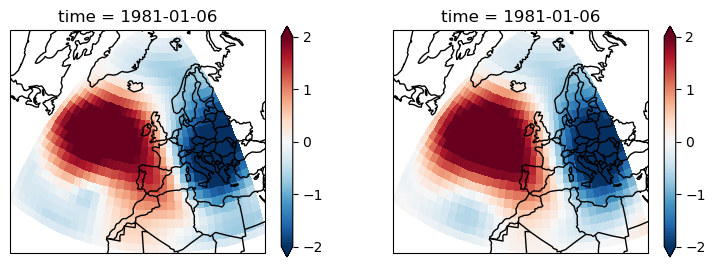

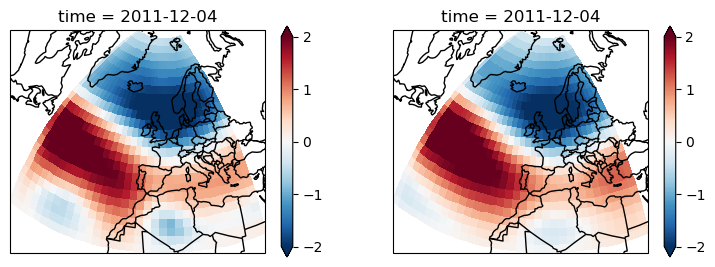

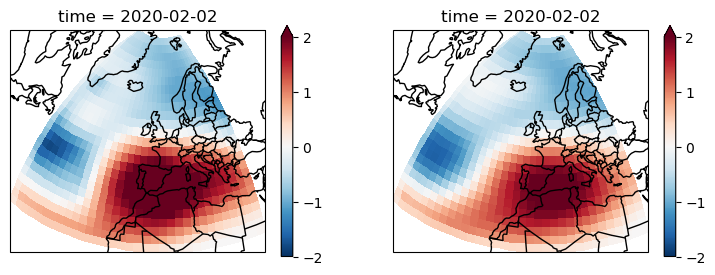

In [22]:
for i in [5, 4660, 5930]:

    fig = plt.figure(figsize=[14,3])

    ax1 = fig.add_subplot(131, projection=ccrs.Orthographic(0,45))
    z500[i, :, :].plot(ax=ax1, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    ax1.coastlines()
    ax1.add_feature(cartopy.feature.BORDERS)

    ax2 = fig.add_subplot(132, projection = ccrs.Orthographic(0,45))
    reconstructed_xr[i, :, :].plot(ax=ax2, cmap='RdBu_r', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    ax2.coastlines()
    ax2.add_feature(cartopy.feature.BORDERS)

## Skill score

In [23]:
final_labels = np.zeros(X.shape[0])
for i in range(0, X.shape[0]):
    max_prob = np.max(c_enc[i,:])
    idx = np.argmax(c_enc[i,:])
    final_labels[i] = idx

In [24]:
# get maximum likelihood labels

df = pd.DataFrame(data=c_enc)
df['label'] = final_labels
#df.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'.csv')

print('calculating skill score')

bss_95 = sc.calculate_95pc_skill_score_probabilistic(cluster_number_z500 = cluster_number, 
                                                  z500_cluster_probabilities = c_enc, 
                                                  pr_spatial = pr_spatial)

print(bss_95)

bss_cluster = sc.calculate_cluster_skill_score_probabilistic(cluster_number_pr = 5, 
                                                             cluster_number_z500 = cluster_number, 
                                                             pr_cluster_labels = np.array(pr_labels['labels']),
                                                             z500_cluster_probabilities = c_enc)

print(bss_cluster)

bss_tercile = sc.calculate_tercile_skill_score_probabilistic(cluster_number_z500 = cluster_number, 
                                                  z500_cluster_probabilities = c_enc, 
                                                  pr_spatial = pr_spatial)

print(bss_tercile)

# FIRST ROUND
#df = pd.DataFrame(data={'k': [cluster_number], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
#df.to_csv(filepath+'skill_score.csv', index=False)

# OTHER ROUND
df_prior = pd.read_csv(filepath+'skill_score.csv')
df = pd.DataFrame(data={'k': [cluster_number], 'bss_cluster': [bss_cluster], 'bss_95': [bss_95], 'bss_tercile': [bss_tercile]})
df_new = df_prior.append(df)
df_new.to_csv(filepath+'skill_score.csv', index=False)

calculating skill score
0.08939297771150123
0.217724802002485
0.14683119370456632


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_74643/3525622964.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


### Cluster centers

In [25]:
# re-order labels

precip_sum = pd.DataFrame(pr_spatial.values[:6352]).groupby(final_labels).sum().reset_index()
precip_sum['index']=precip_sum['index'].astype('int')
precip_sum = precip_sum.rename(columns={"index": "index_old"})
precip_sum = precip_sum.sort_values(by=0, ascending=False)
precip_sum['index_new'] = np.arange(precip_sum.shape[0])

labels_reordered = final_labels.copy()

for i in range(len(final_labels)):
    
    new_label = precip_sum[precip_sum['index_old']==final_labels[i].astype('int')]['index_new'].values[0]
    
    labels_reordered[i] = new_label
    
precip_sum['index_old'].values.tolist()

[3, 4, 5, 0, 2, 1]

In [26]:



# save re-ordered cluster labels and probabilities

df = pd.DataFrame(data=c_enc)
df_reordered = df[precip_sum['index_old'].values.tolist()]
df_reordered.columns= [*range(cluster_number)]
df_reordered['label'] = labels_reordered

#df_reordered.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'_preciporder.csv')

df['label'] = final_labels
df.to_csv(filepath+'cluster_probabilities_'+str(cluster_number)+'.csv')



/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_74643/1446565730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reordered['label'] = labels_reordered


In [27]:
# save cluster centers

z500_labels_preciporder = z500.assign_coords(label=("time", labels_reordered))/weights
z500_labels = z500.assign_coords(label=("time", final_labels))/weights

means_preciporder = z500_labels_preciporder.groupby('label').mean()
means = z500_labels.groupby('label').mean()

means_flat = cf.reshape_data_for_clustering(means)
means_flat_preciporder = cf.reshape_data_for_clustering(means_preciporder)

df1 = pd.DataFrame(data=means_flat)
df1.to_csv(filepath+'cluster_centers_'+str(cluster_number)+'.csv')

df2 = pd.DataFrame(data=means_flat_preciporder)
df2.to_csv(filepath+'cluster_centers_'+str(cluster_number)+'_preciporder.csv')

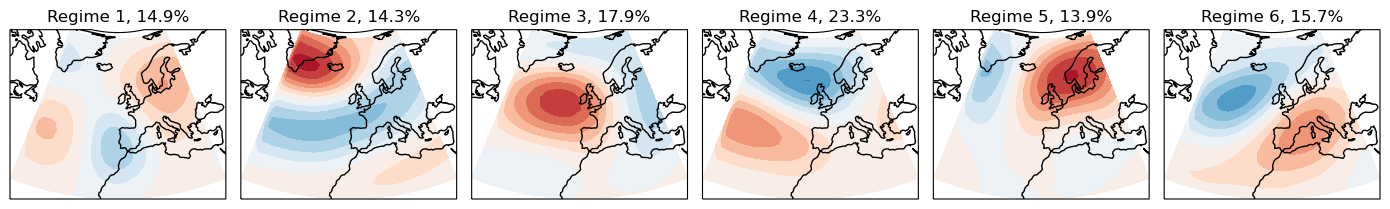

In [28]:
cluster_centers_vis = cf.visualise_contourplot_labels_8(cluster_centers = means_preciporder, unit = '[m]', 
                                            regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'], 
                                             vmin=-4, vmax=4.5, steps=0.5, 
                                             color_scheme = 'RdBu_r', 
                                                      labels_data = X, labels=labels_reordered,
                                                      borders=False, 
                                                     col_number=cluster_number, projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50))

plt.savefig(filepath+'cluster_centers_'+str(cluster_number)+'.png')

**Precipitation odds ratio**

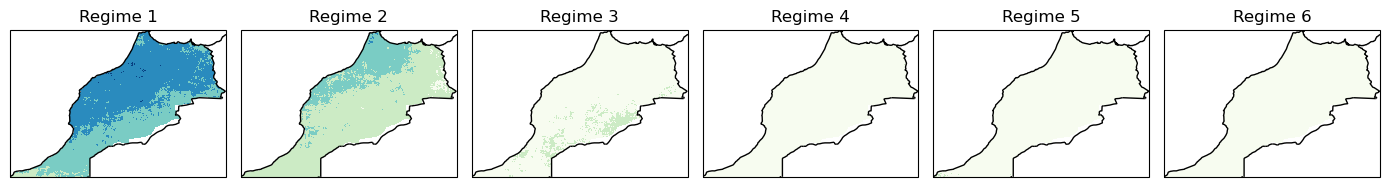

In [29]:
pr_qn95_ratio = cf.calculate_conditional_probability_change_label(threshold_matrix = threshold_qn95, 
                                                        labels=labels_reordered,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio_8(dataset_xarray = pr_qn95_ratio, unit='', 
                                   color_scheme = 'GnBu', vmin = 0, vmax=5, steps=6, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8', 'Regime 9', 'Regime 10'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0), 
                                               col_number=cluster_number)

plt.savefig(filepath+'precip_odds_ratio_'+str(cluster_number)+'_preciporder.png')


### Persistence & Silhouette

In [33]:
persistence = cf.calculate_regime_length(labels_reordered.astype(int)).groupby('Regime').mean()['Length'].reset_index()

print(persistence['Length'].mean())

# FIRST ROUND
#df = pd.DataFrame(data={'k': [str(cluster_number)]*cluster_number,
#                        'Method': ['CMM-VAE']*cluster_number,
#                        'Regime': persistence['Regime'].values, 
#                        'Persistence': persistence['Length'].values})
#df.to_csv(filepath+'persistence.csv', index=False)


# OTHER ROUND
df_prior = pd.read_csv(filepath+'persistence.csv')
df = pd.DataFrame(data={'k': [str(cluster_number)]*cluster_number, 
                        'Method': ['CMM-VAE']*cluster_number,
                        'Regime': persistence['Regime'].values, 
                        'Persistence': persistence['Length'].values})
df_new = df_prior.append(df)
df_new.to_csv(filepath+'persistence.csv', index=False)

sil_score = silhouette_score(cf.reshape_data_for_clustering(z500), final_labels)
print(sil_score)

# FIRST ROUND
#df = pd.DataFrame(data={'k': [cluster_number], 'silhouette_score': [sil_score], 'method': ['CMM-VAE']})
#df.to_csv(filepath+'silhouette_score.csv', index=False)

# OTHER ROUND
df_prior = pd.read_csv(filepath+'silhouette_score.csv')
df = pd.DataFrame(data={'k': [cluster_number], 'silhouette_score': [sil_score], 'method': ['CMM-VAE']})
df_new = df_prior.append(df)
df_new.to_csv(filepath+'silhouette_score.csv', index=False)

6.119244016237161


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_74643/3542464948.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)


0.08138521891441126


/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_74643/3542464948.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_prior.append(df)
